In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('../names.txt', 'r') as file:
    names = file.read().split()

print('Total names:', len(names))
print(names[:5])

Total names: 32033
['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [22]:
# Form stoi and itos
vocab = sorted(list(set(''.join(names))))
stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi['.'] = 0
itos = {stoi[s]: s for s in stoi}

vocab_size = len(stoi)

In [6]:
block_size = 3

In [ ]:
def form_dataset(words):
    X = []
    Y = []

    for word in words:
        word = ['.'] * block_size + list(word) + ['.']
        for ind in range(3, len(word)):
            X.append([stoi[x] for x in word[ind-3:ind]])
            Y.append(stoi[word[ind]])
            # print(''.join(word[ind-3:ind]), '--->', word[ind])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

### Form dataset
Divide into 3: usual splits are 80, 10, 10

In [64]:
import random
random.seed(42)
random.shuffle(names)

X, Y = form_dataset(names)

n1 = int(0.8 * X.shape[0])
n2 = int(0.9 * X.shape[0])
Xtr, Xdev, Xts = X.tensor_split((n1, n2), dim=0) # input is split into X[:n1], X[n1:n2] and X[n2:]
Ytr, Ydev, Yts = Y.tensor_split((n1, n2), dim=0)
print(Ytr.shape, Ydev.shape, Yts.shape)

torch.Size([182516]) torch.Size([22815]) torch.Size([22815])


### Embedding data

In [65]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn(block_size * n_embd, n_hidden, generator=g)
b1 = torch.randn(n_hidden,                      generator=g)

W2 = torch.randn(n_hidden, vocab_size,          generator=g) # Output of emb @ W1 + b1 will feed into W2 for multiplication
b2 = torch.randn(vocab_size,                    generator=g)

In [66]:
parameters = [C, W1, b1, W2, b2]
total_params = 0
for p in parameters:
    total_params += p.nelement()
    p.requires_grad = True

lossi = []

In [67]:
batch_size = 32 # Take 32 training data points for each loop of gradient descend

for _ in range(1000):
    batch_inds = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,))
    Xb, Yb = Xtr[batch_inds], Ytr[batch_inds]
    
    embs = C[Xb]
    h = torch.tanh(embs.view(-1, block_size * n_embd) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    print(loss.item())
    lossi.append(loss.item())

    for p in parameters:
        p.grad = None
    
    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad    

25.273284912109375
23.92198944091797
19.506547927856445
19.486358642578125
24.668027877807617
19.69144058227539
18.809049606323242
20.19476318359375
15.222339630126953
17.44417381286621
15.655916213989258
17.58625030517578
19.131561279296875
18.82672119140625
17.14451789855957
15.175596237182617
18.84638023376465
15.84564208984375
12.303556442260742
12.996296882629395
14.026228904724121
14.749465942382812
14.368063926696777
13.271141052246094
14.278203964233398
15.221312522888184
14.238116264343262
15.96493911743164
9.786648750305176
11.468679428100586
15.91458511352539
14.306120872497559
12.523776054382324
14.471574783325195
10.941568374633789
16.388118743896484
13.603529930114746
9.0439453125
13.275187492370605
12.8829345703125
16.54520034790039
10.181615829467773
12.401124954223633
10.065047264099121
8.05288314819336
9.66749095916748
10.114460945129395
13.25572395324707
8.920880317687988
8.943517684936523
12.583890914916992
11.377817153930664
11.659249305725098
11.951948165893555
9.

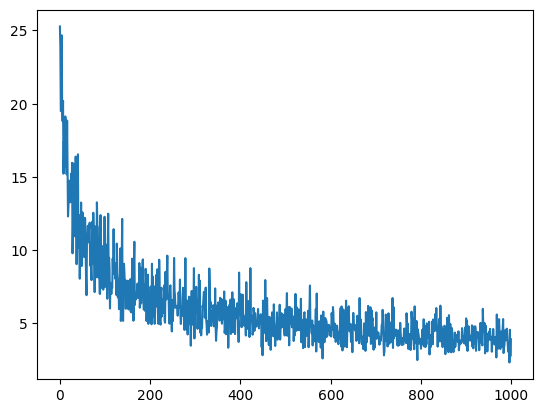

In [68]:
plt.plot(lossi)